# Add alpha factors

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load MERVAL OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

Set data store location:

In [75]:
DATA_STORE = './data/assets.h5'

In [76]:
YEAR = 12

In [77]:
START = 1995
END = 2017

In [78]:
with pd.HDFStore(DATA_STORE, 'r') as store:
    prices = (store['merval/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['merval/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [79]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74207 entries, ('BBAR.BA', Timestamp('2000-01-03 00:00:00')) to ('YPFD.BA', Timestamp('2017-12-28 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    74207 non-null  float64
 1   high    74207 non-null  float64
 2   low     74207 non-null  float64
 3   close   74207 non-null  float64
 4   volume  74207 non-null  int64  
 5   sector  74207 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 3.8+ MB


In [80]:
len(prices.index.unique('ticker'))

21

## Remove stocks with less than ten years of data

In [81]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [82]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71159 entries, ('BBAR.BA', Timestamp('2000-01-03 00:00:00')) to ('YPFD.BA', Timestamp('2017-12-28 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    71159 non-null  float64
 1   high    71159 non-null  float64
 2   low     71159 non-null  float64
 3   close   71159 non-null  float64
 4   volume  71159 non-null  int64  
 5   sector  71159 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 3.6+ MB


In [83]:
len(prices.index.unique('ticker'))

17

## Add some Basic Factors

### Compute the Relative Strength Index

In [84]:
rsi = prices.groupby(level='ticker').close.apply(RSI)
prices['rsi'] = rsi.values

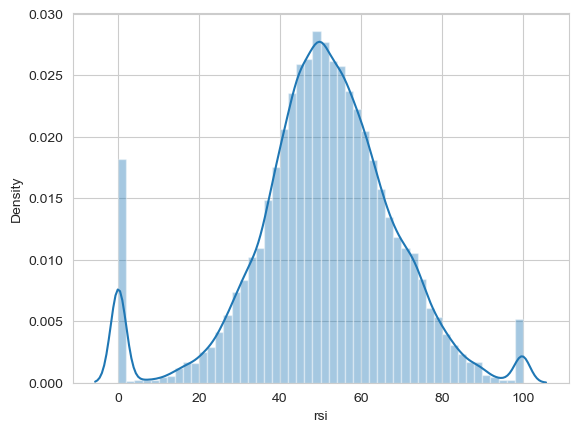

In [85]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [86]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [87]:
bb = prices.groupby(level='ticker').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_mid'] = bb['bb_mid'].values
prices['bb_low'] = bb['bb_low'].values


In [88]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71159 entries, ('BBAR.BA', Timestamp('2000-01-03 00:00:00')) to ('YPFD.BA', Timestamp('2017-12-28 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     71159 non-null  float64
 1   high     71159 non-null  float64
 2   low      71159 non-null  float64
 3   close    71159 non-null  float64
 4   volume   71159 non-null  int64  
 5   sector   71159 non-null  object 
 6   rsi      70921 non-null  float64
 7   bb_high  70836 non-null  float64
 8   bb_mid   70836 non-null  float64
 9   bb_low   70836 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 5.8+ MB


In [89]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,70836.000000,70836.000000,70836.000000
mean,1.635314,1.576892,1.518470
std,1.403461,1.381397,1.361427
min,-0.030734,-0.033302,-0.340238
25%,0.624896,0.575627,0.524533
50%,1.200300,1.136124,1.083464
75%,2.315977,2.239133,2.159172
max,6.363781,6.223842,6.193394


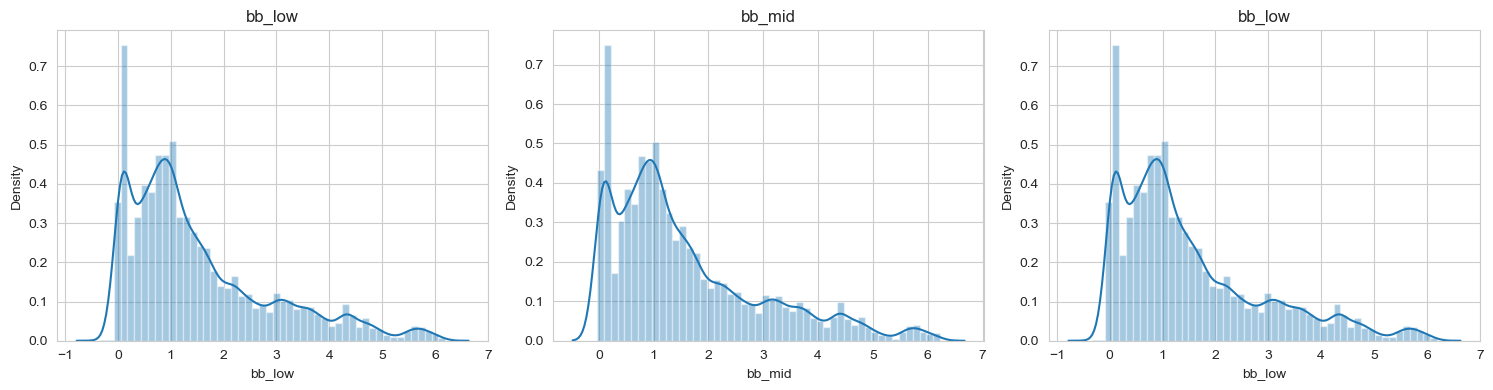

In [90]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [91]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

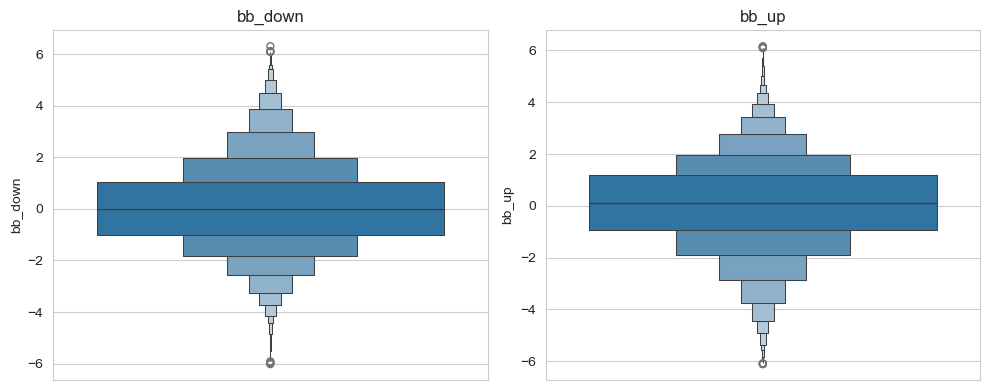

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [93]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [94]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [95]:
prices['atr'] = by_ticker.apply(compute_atr)

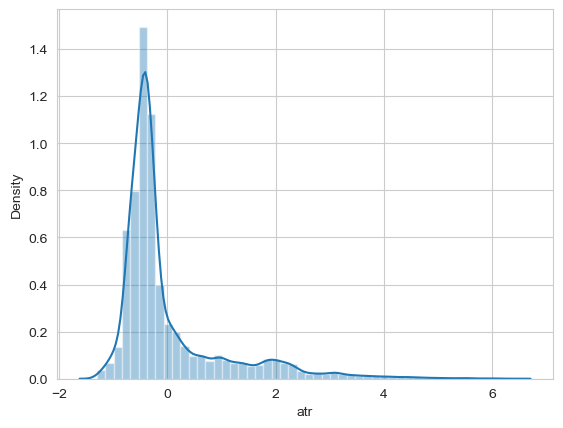

In [96]:
sns.distplot(prices.atr);

In [97]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

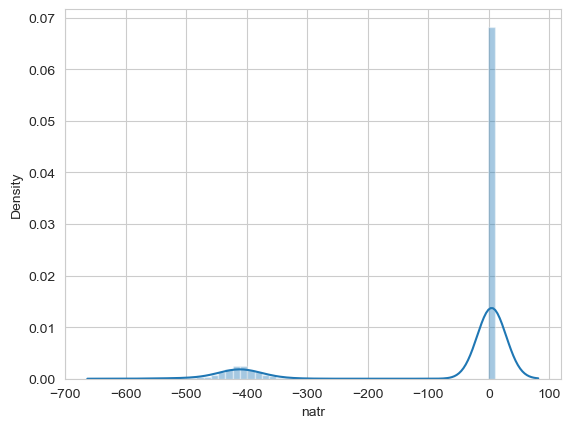

In [98]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [99]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd).values

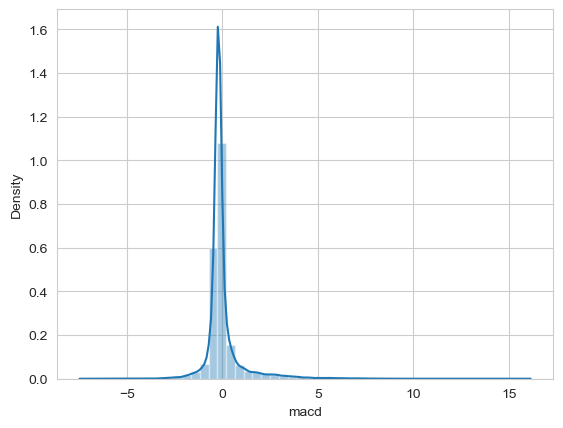

In [100]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [101]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [102]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [103]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71159 entries, ('BBAR.BA', Timestamp('2000-01-03 00:00:00')) to ('YPFD.BA', Timestamp('2017-12-28 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           71159 non-null  float64
 1   high           71159 non-null  float64
 2   low            71159 non-null  float64
 3   close          71159 non-null  float64
 4   volume         71159 non-null  int64  
 5   sector         71159 non-null  object 
 6   rsi            70921 non-null  float64
 7   bb_high        70836 non-null  float64
 8   bb_mid         70836 non-null  float64
 9   bb_low         70836 non-null  float64
 10  bb_up          70836 non-null  float64
 11  bb_down        70836 non-null  float64
 12  atr            70921 non-null  float64
 13  natr           70921 non-null  float64
 14  macd           70598 non-null  float64
 15  dollar_volume  71159 non-null  float64
dtypes: float64

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [104]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [105]:
prices = prices.unstack('ticker')

In [106]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3407 entries, ('BBAR.BA', Timestamp('2000-01-31 00:00:00')) to ('EDN.BA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  3407 non-null   float64
 1   atr            3407 non-null   float64
 2   bb_down        3407 non-null   float64
 3   bb_high        3407 non-null   float64
 4   bb_low         3407 non-null   float64
 5   bb_mid         3407 non-null   float64
 6   bb_up          3407 non-null   float64
 7   close          3407 non-null   float64
 8   macd           3407 non-null   float64
 9   natr           3407 non-null   float64
 10  rsi            3407 non-null   float64
 11  sector         3407 non-null   object 
dtypes: float64(11), object(1)
memory usage: 340.0+ KB


## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [108]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [109]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3390 entries, ('BBAR.BA', Timestamp('2000-02-29 00:00:00')) to ('EDN.BA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   3390 non-null   float64
 1   return_3m   3356 non-null   float64
 2   return_6m   3305 non-null   float64
 3   return_12m  3203 non-null   float64
dtypes: float64(4)
memory usage: 118.3+ KB


In [110]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,3390.000000,3356.000000,3305.000000,3203.000000
mean,0.029254,0.023562,0.021866,0.021520
std,0.145139,0.091051,0.067598,0.053766
min,-0.320604,-0.220330,-0.159666,-0.113709
25%,-0.053313,-0.026835,-0.017171,-0.007841
50%,0.005236,0.012151,0.019141,0.022147
75%,0.100000,0.070729,0.061979,0.051244
max,0.537209,0.323021,0.230095,0.211036


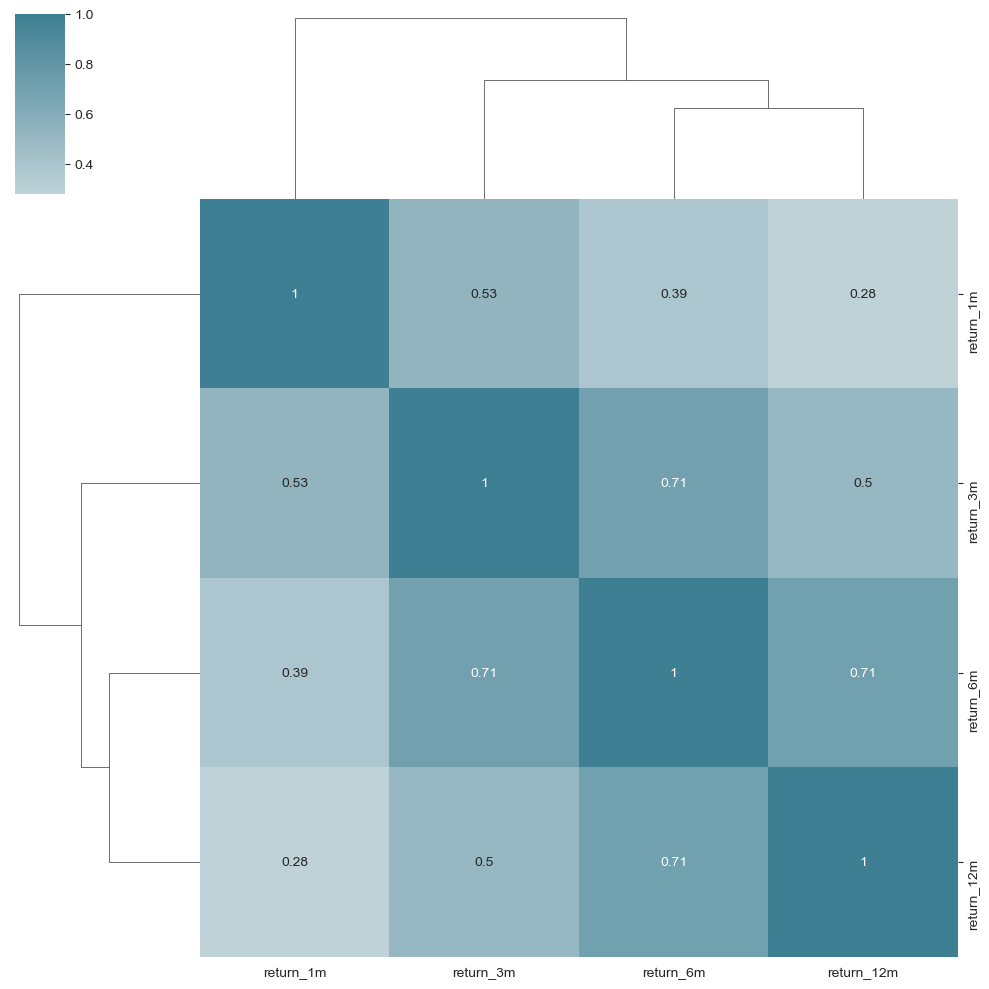

In [111]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [112]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, ('BBAR.BA', Timestamp('2001-01-31 00:00:00')) to ('EDN.BA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  3203 non-null   float64
 1   atr            3203 non-null   float64
 2   bb_down        3203 non-null   float64
 3   bb_high        3203 non-null   float64
 4   bb_low         3203 non-null   float64
 5   bb_mid         3203 non-null   float64
 6   bb_up          3203 non-null   float64
 7   macd           3203 non-null   float64
 8   natr           3203 non-null   float64
 9   rsi            3203 non-null   float64
 10  sector         3203 non-null   object 
 11  return_1m      3203 non-null   float64
 12  return_3m      3203 non-null   float64
 13  return_6m      3203 non-null   float64
 14  return_12m     3203 non-null   float64
dtypes: float64(14), object(1)
memory usage: 395.3+ KB


In [113]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [114]:
tickers_left = len(data.index.unique('ticker'))
f"the result is {tickers_left} tickers"

'the result is 17 tickers'

## Rolling Factor Betas

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

We can use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [115]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 1995-01-31 to 2024-04-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  352 non-null    float64
 1   SMB     352 non-null    float64
 2   HML     352 non-null    float64
 3   RMW     352 non-null    float64
 4   CMA     352 non-null    float64
dtypes: float64(5)
memory usage: 16.5 KB


In [116]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, ('ALUA.BA', Timestamp('2003-08-31 00:00:00')) to ('YPFD.BA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     3203 non-null   float64
 1   SMB        3203 non-null   float64
 2   HML        3203 non-null   float64
 3   RMW        3203 non-null   float64
 4   CMA        3203 non-null   float64
 5   return_1m  3203 non-null   float64
dtypes: float64(6)
memory usage: 170.6+ KB


In [117]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,3203.000000,3203.000000,3203.000000,3203.000000,3203.000000,3203.000000
mean,0.005886,0.002993,0.001180,0.003522,0.001641,0.026493
std,0.042373,0.025560,0.026764,0.021874,0.017472,0.140722
min,-0.172300,-0.064300,-0.112900,-0.092000,-0.050300,-0.396004
25%,-0.017600,-0.014350,-0.013200,-0.009300,-0.009900,-0.057284
50%,0.010900,0.002500,0.000000,0.004400,-0.000100,0.006008
75%,0.031300,0.020600,0.015300,0.013600,0.010600,0.095316
max,0.113500,0.071300,0.124700,0.091000,0.090700,0.619009


In [118]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [119]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,2200.000000,2.200000e+03,2200.000000,2200.000000,2200.000000,3203.000000
mean,-0.012851,6.739442e-02,-0.345371,-0.168758,-0.017561,-0.327731
std,0.527363,8.925678e-01,0.888429,1.237940,1.342608,1.789705
min,-2.071165,-2.673345e+00,-3.045462,-4.136258,-4.521266,-9.586544
25%,-0.330730,-4.924212e-01,-0.889365,-0.869134,-0.870442,-1.039556
50%,0.050446,2.007477e-16,-0.336032,-0.167623,-0.020236,0.000000
75%,0.354266,5.082923e-01,0.089825,0.725118,0.926271,0.185938
max,1.414388,3.124956e+00,3.043994,2.972492,3.762485,6.677564


In [120]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,2200.000000,2.200000e+03,2200.000000,2200.000000,2200.000000,3203.000000
mean,-0.012851,6.739442e-02,-0.345371,-0.168758,-0.017561,-0.327731
std,0.527363,8.925678e-01,0.888429,1.237940,1.342608,1.789705
min,-2.071165,-2.673345e+00,-3.045462,-4.136258,-4.521266,-9.586544
25%,-0.330730,-4.924212e-01,-0.889365,-0.869134,-0.870442,-1.039556
50%,0.050446,2.007477e-16,-0.336032,-0.167623,-0.020236,0.000000
75%,0.354266,5.082923e-01,0.089825,0.725118,0.926271,0.185938
max,1.414388,3.124956e+00,3.043994,2.972492,3.762485,6.677564


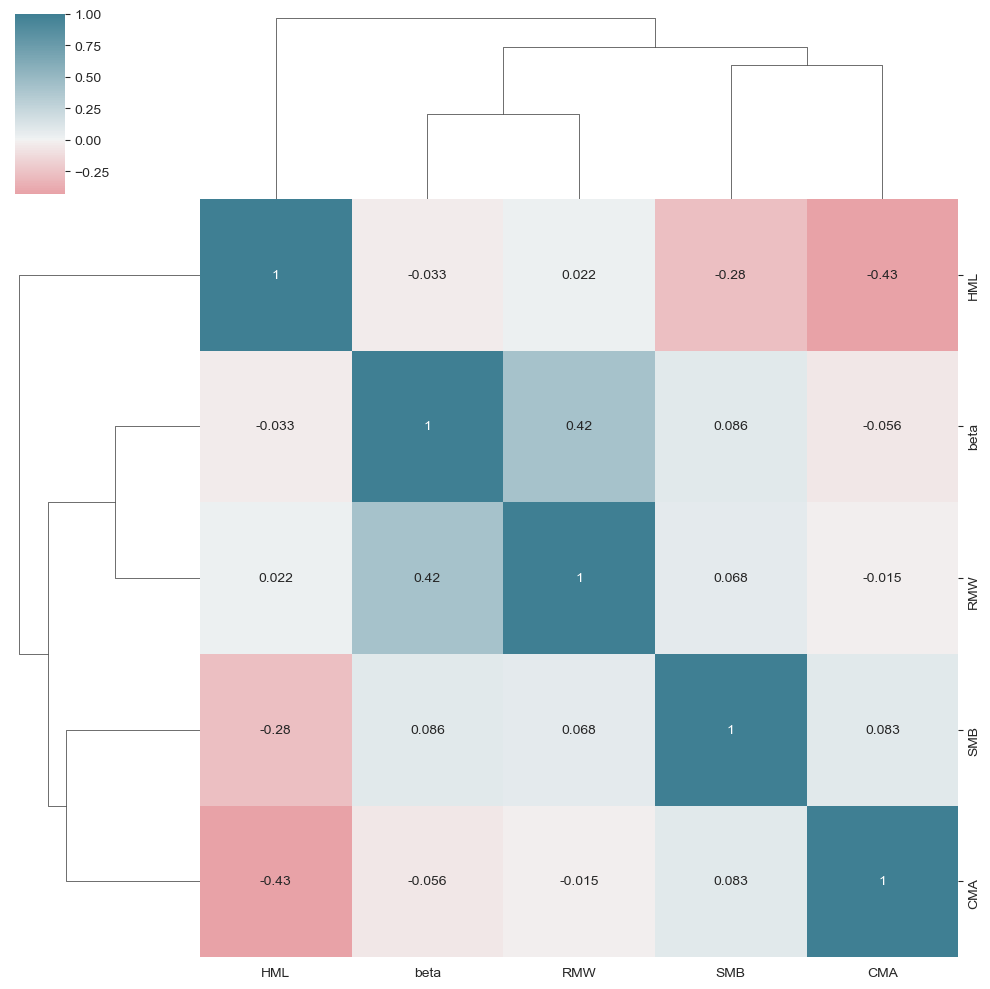

In [121]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [122]:
data = (data
      .join(betas
          .groupby(level='ticker')
          .shift())
     .dropna()
     .sort_index())

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2183 entries, ('ALUA.BA', Timestamp('2008-08-31 00:00:00')) to ('YPFD.BA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  2183 non-null   float64
 1   atr            2183 non-null   float64
 2   bb_down        2183 non-null   float64
 3   bb_high        2183 non-null   float64
 4   bb_low         2183 non-null   float64
 5   bb_mid         2183 non-null   float64
 6   bb_up          2183 non-null   float64
 7   macd           2183 non-null   float64
 8   natr           2183 non-null   float64
 9   rsi            2183 non-null   float64
 10  sector         2183 non-null   object 
 11  return_1m      2183 non-null   float64
 12  return_3m      2183 non-null   float64
 13  return_6m      2183 non-null   float64
 14  return_12m     2183 non-null   float64
 15  beta           2183 non-null   float64
 16  SMB        

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [124]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [125]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [126]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [127]:
data = data.dropna()

In [128]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2166 entries, ('ALUA.BA', Timestamp('2008-08-31 00:00:00')) to ('YPFD.BA', Timestamp('2017-11-30 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  2166 non-null   float64
 1   atr            2166 non-null   float64
 2   bb_down        2166 non-null   float64
 3   bb_high        2166 non-null   float64
 4   bb_low         2166 non-null   float64
 5   bb_mid         2166 non-null   float64
 6   bb_up          2166 non-null   float64
 7   macd           2166 non-null   float64
 8   natr           2166 non-null   float64
 9   rsi            2166 non-null   float64
 10  sector         2166 non-null   object 
 11  return_1m      2166 non-null   float64
 12  return_3m      2166 non-null   float64
 13  return_6m      2166 non-null   float64
 14  return_12m     2166 non-null   float64
 15  beta           2166 non-null   float64
 16  SMB        

## Sector Breakdown

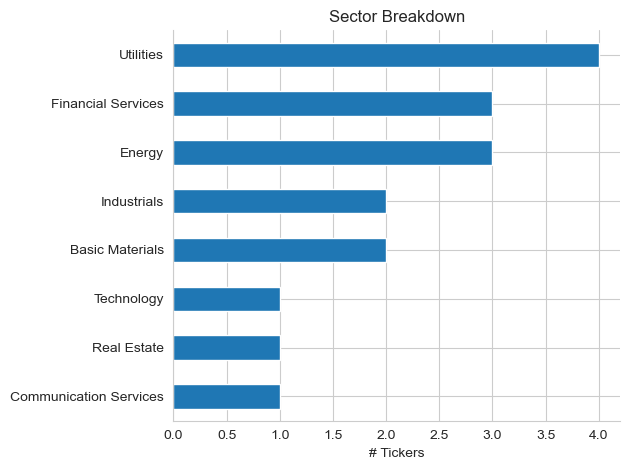

In [129]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [139]:
with pd.HDFStore('data.h5') as store:
    store.put('equities/monthly', data)

## Evaluate mutual information

In [140]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [141]:
mi = mutual_info_regression(X=X, y=data.target)

In [142]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

bb_mid           0.138116
bb_low           0.119419
return_12m       0.113035
bb_high          0.112994
momentum_6       0.112906
atr              0.105957
momentum_3_12    0.101571
momentum_12      0.098426
natr             0.098125
momentum_3       0.095844
dtype: float64

In [143]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [144]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

bb_low        0.133918
bb_high       0.103272
bb_mid        0.097955
rsi           0.037188
momentum_6    0.032239
month         0.027280
return_3m     0.026193
momentum_3    0.026050
atr           0.024725
year          0.024385
dtype: float64

In [145]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [146]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

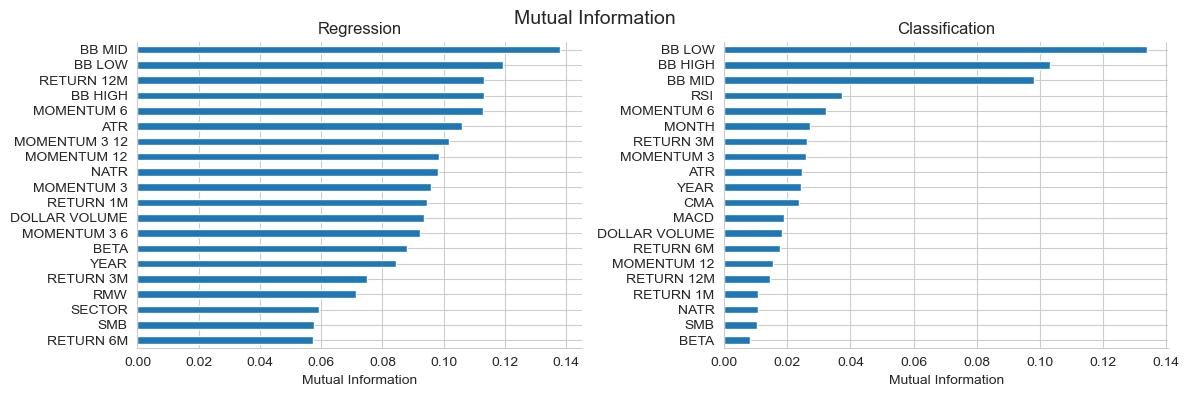

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)